In [1]:
import uproot
import polars as pl
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
%config InlineBackend.figure_format = "retina"

In [2]:
pl.__version__

'1.33.1'

In [3]:
#Save Loading relevant event infos
with uproot.open("/eos/home-p/pigrange/nusyst_genie_extracted.root") as f:
    genie = f["genie_dump"]
    keys = genie.keys()
    loaded = {}
    for key in tqdm(keys):
        loaded[key] = genie[key].array(library="np")
    genie = pl.DataFrame(loaded)


with uproot.open('/eos/home-p/pigrange/nusyst_new_sum.root') as f:
    cols = ['EventID', 'SubRun', 'Run', 'Ecalo', 'Elep_calo', 'Emu_range', 'Emu_mcs', 'Ee_calo', 'Pmu_x', 'Pmu_y', 'Pmu_z', 'Pe_x', 'Pe_y', 'Pe_z']
    reco = f['SystWeights'].arrays(cols, library='pd')
    reco = pl.from_pandas(reco)

genie = pl.concat([genie, reco], how='horizontal')

100%|██████████| 22/22 [00:30<00:00,  1.38s/it]


In [4]:
#Filtering CCQE events and saving the infos as parquet file for faster loading
genie_ccqe = genie.filter(
    pl.col('proc') == '<QES - Weak[CC]>'
)
genie_ccqe.write_parquet('parquet/genie_ccqe.parquet')

In [8]:
#Loanding the systs and saving the data as parquet files for faster reading later on

relevant_systs = [
    "FrCEx_N",
    "FrInel_N",
    "FrAbs_N",
    "FrPiProd_N",
    "MFP_N",
    "ZExpA1CCQE",
    "ZExpA2CCQE",
    "ZExpA3CCQE",
    "ZExpA4CCQE"
]

with uproot.open('nusyst_new_sum.root') as f:
    syst_id = f['SRGlobal/wgts.params.id'].array(library='np')[0]
    syst_nshifts = f['SRGlobal/wgts.params.nshifts'].array(library='np')[0]
    syst_name = f['SRGlobal/wgts.params.name'].array(library='np')[0]
    
    systs_header = pl.DataFrame({
        'id': syst_id,
        'nshifts': syst_nshifts,
        'name': syst_name
    })
    
    for syst in tqdm(systs_header.iter_rows(named=True), total=len(systs_header)):
        if syst['name'] not in relevant_systs:
            continue
        variations = f['SystWeights'][syst['name']].array(library='np')
        col_names = [f'{syst["name"]}_{i}' for i in range(syst['nshifts'])]
        variations = pl.from_numpy(variations, schema=col_names)
        variations = pl.concat([genie, variations], how='horizontal')
        variations_ccqe = variations.filter(
            pl.col('proc') == '<QES - Weak[CC]>'
        )
        variations_ccqe.write_parquet(f'parquet/{syst["name"]}_ccqe.parquet')
    # systs = pl.concat(all_variations, how='horizontal')

100%|██████████| 84/84 [17:30<00:00, 12.50s/it]  


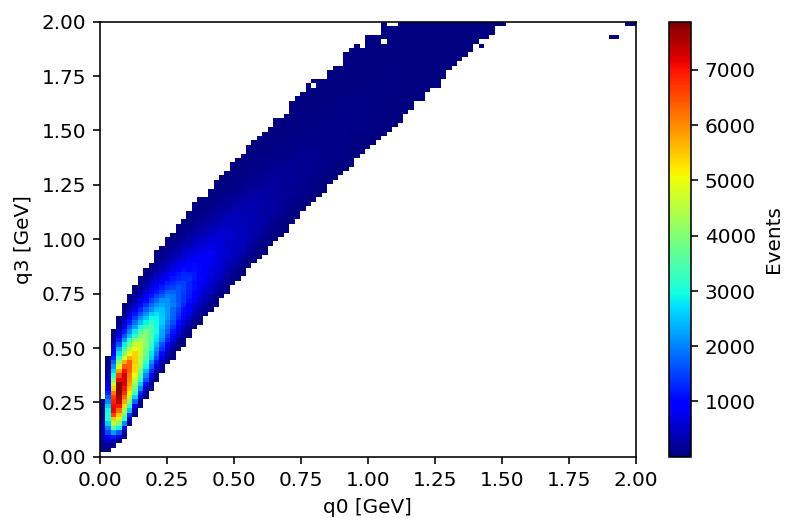

In [5]:
from scipy.stats import binned_statistic

#Making some plot of q0 q3
numu_ccqe = genie_ccqe.filter(
    pl.col('pdg') == 14
).with_columns(
    direc_true = pl.col('nu_Py')/pl.col('nu_E'),
    direc_reco = pl.col('Pmu_y'),
    pmiss = (pl.col('hitnuc_Px')**2 + pl.col('hitnuc_Py')**2 + pl.col('hitnuc_Pz')**2).sqrt()*1000,
).with_columns(
    direc_res = (pl.col('direc_reco').arccos() - pl.col('direc_true').arccos())*180/np.pi
).filter(
    pl.col('direc_reco').abs() <= 1,
)
numu_ccqe.columns
plt.hist2d(numu_ccqe['q0'], numu_ccqe['q3'], bins=(np.linspace(0, 2, 100), np.linspace(0, 2, 100)), cmap='jet', cmin=1)
plt.xlabel('q0 [GeV]')
plt.ylabel('q3 [GeV]')
plt.colorbar(label='Events')

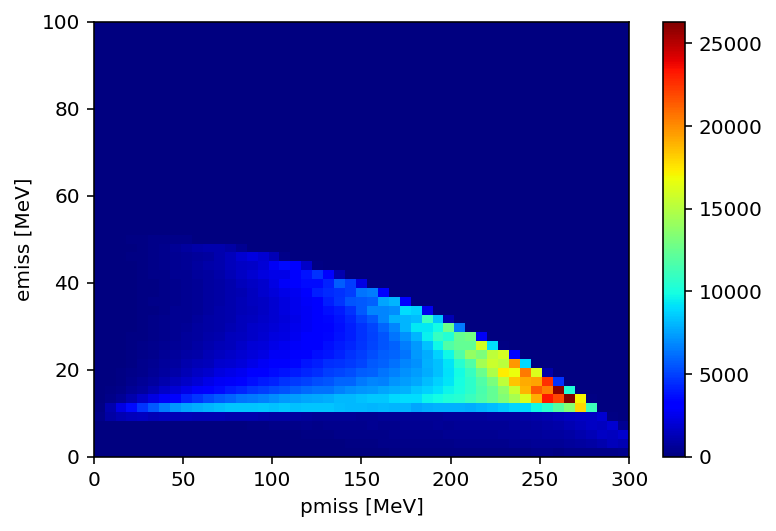

In [7]:
#pmiss emiss plot

nucleon_mass = 0.93956542052
data = genie_ccqe.with_columns(
    pmiss = (pl.col('hitnuc_Px')**2 + pl.col('hitnuc_Py')**2 + pl.col('hitnuc_Pz')**2).sqrt(),
    emiss = nucleon_mass - pl.col('hitnuc_E') ,
)

pbins = np.linspace(0, 300, 50)
ebins = np.linspace(0, 100, 50)
plt.figure()
plt.hist2d(data['pmiss']*1000, data['emiss']*1000, bins=(pbins, ebins), cmap='jet');
plt.xlabel('pmiss [MeV]')
plt.ylabel('emiss [MeV]')
plt.colorbar()

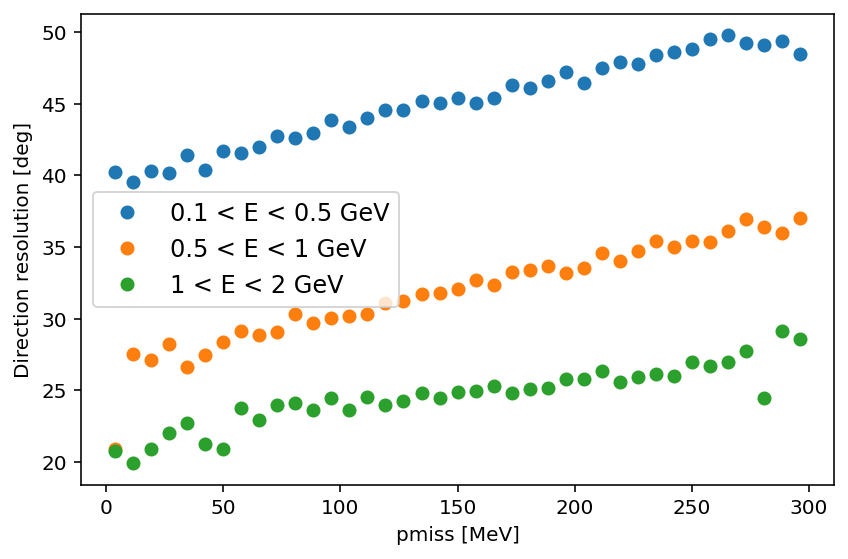

In [6]:
#Plotting the direction reco as a function of energy
# Ebins = np.linspace(0, 2, 40)
Pbins = np.linspace(0, 300, 40)
Ecenters = (Pbins[1:] + Pbins[:-1])/2
for Erange in ([0.1, 0.5], [0.5, 1], [1, 2]):
    selected = numu_ccqe.filter(
        pl.col('nu_E') > Erange[0],
        pl.col('nu_E') < Erange[1]
    )
    std = binned_statistic(selected['pmiss'], selected['direc_res'], statistic='std', bins=Pbins).statistic
    plt.errorbar(Ecenters, std, fmt='o', label=f'{Erange[0]} < E < {Erange[1]} GeV')
plt.xlabel('pmiss [MeV]')
plt.ylabel('Direction resolution [deg]')
plt.legend(fontsize=12)
plt.tight_layout()

In [ ]:
#Example of interesting plots to make

relevant_systs = [
    "FrCEx_N",
    "FrInel_N",
    "FrAbs_N",
    "FrPiProd_N",
    "MFP_N",
    "ZExpA1CCQE",
    "ZExpA2CCQE",
    "ZExpA3CCQE",
    "ZExpA4CCQE"
]

from scipy.stats import binned_statistic


def plot_variations(data, syst, var, bins, logx=False, xlabel=None):
    
    plt.figure()
    nominal_index = systs_header.filter(pl.col('name') == syst)['nshifts'][0] // 2
    for idx in range(nominal_index - 1, nominal_index + 2):
        plt.hist(data.select(var), bins=bins, histtype='step', weights=data[f'{syst}_{idx}'], label=rf'{idx - nominal_index}$\sigma$', lw=2);
    if logx:
        plt.xscale('log')
    plt.legend(title=syst)
    if xlabel is not None:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(var)
    plt.ylabel('# Events')
    plt.tight_layout()

def plot_variations_ratio(data, syst, var, bins, logx=False, xlabel=None):
    plt.figure()

    nominal_index = systs_header.filter(pl.col('name') == syst)['nshifts'][0] // 2
    events_var = data.select(var).to_numpy().T

    nominal = np.histogram(events_var[0], bins=bins, weights=data[f'{syst}_{nominal_index}'])[0]
    for idx in range(nominal_index - 1, nominal_index + 2):
        weights = data[f'{syst}_{idx}']
        hist = np.histogram(events_var[0], bins=bins, weights=weights)[0]
        plt.plot(bins[:-1], hist / nominal, label=rf'{idx - nominal_index:+d}$\sigma$', lw=2);
    if logx:
        plt.xscale('log')
    plt.legend(title=syst)
    if xlabel is not None:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(var)
    plt.ylabel('Ratio to nominal')
    plt.tight_layout()

def plot_variations_2d(data, syst, var, bins, logx=False, logy=False, xlabel=None, ylabel=None, nb_sigmas=1):
    assert(len(var) == 2)
    assert(len(bins) == 2)
    plt.figure()

    nominal_index = systs_header.filter(pl.col('name') == syst)['nshifts'][0] // 2
    events_var = data.select(var).to_numpy().T

    nominal = np.histogram2d(events_var[0], events_var[1], bins=bins, weights=data[f'{syst}_{nominal_index}'])[0]
    assert(nominal_index + nb_sigmas < systs_header.filter(pl.col('name') == syst)['nshifts'][0])
    weights = data[f'{syst}_{nominal_index+nb_sigmas}']
    hist = np.histogram2d(events_var[0], events_var[1], bins=bins, weights=weights)[0]
    plt.pcolormesh(bins[0], bins[1], (hist / nominal).T, cmap='jet', shading='auto', alpha=1);
    plt.colorbar()
    # plt.imshow(hist / nominal, extent=[bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]]);
    if logx:
        plt.xscale('log')
    if logy:
        plt.yscale('log')
    plt.legend(title=syst)
    if xlabel is not None:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(var[0])
    if ylabel is not None:
        plt.ylabel(ylabel)
    else:
        plt.ylabel(var[1])
    plt.title(rf'({nb_sigmas:+}$\sigma$)Ratio to nominal')
    plt.tight_layout()

# def plot_variations_resolution(data, syst, var1, var2, bins, logx=False):
#     plt.figure()

#     def weighted_std(sample, weights):
#         return np.std(sample, weights=weights)

#     nominal_index = systs_header.filter(pl.col('name') == syst)['nshifts'][0] // 2
#     for idx in range(nominal_index - 1, nominal_index + 2):
#         weights = data[f'{syst}_{idx}'].to_numpy().flat
#         # std = binned_statistic(data.select(var1).to_numpy().flat, data.select(var2).to_numpy().flat, statistic='std', bins=bins).statistic
#         std = binned_statistic(data.select(var1).to_numpy().flat, data.select(var2).to_numpy().flat, statistic=lambda x: weighted_std(x, weights[np.in1d(data, x)]), bins=bins).statistic
#         plt.errorbar(0.5*(bins[:-1] + bins[1:]), std, fmt='o', label=rf'{idx - nominal_index}$\sigma$', lw=2)
#     if logx:
#         plt.xscale('log')
#     plt.legend(title=syst)
#     plt.xlabel(var1)
#     plt.ylabel(var2)
#     plt.tight_layout()

    

# plot_variations_ratio(cc_qe, "ZExpA1CCQE", 'nu_E', np.linspace(0.1, 1, 50),)
for param in tqdm(relevant_systs):
    nshifts = systs_header.filter(pl.col('name') == param)['nshifts'][0]
    if nshifts <= 2:
        continue
    fetched_data = pl.read_parquet(f'parquet/{param}_ccqe.parquet').with_columns(
        direc_true = pl.col('nu_Py')/pl.col('nu_E'),
        direc_reco = pl.when(pl.col('Pmu_y') != 0).then(pl.col('Pmu_y')).otherwise(pl.col('Pe_y')),
        pmiss = (pl.col('hitnuc_Px')**2 + pl.col('hitnuc_Py')**2 + pl.col('hitnuc_Pz')**2).sqrt()*1000,
    ).with_columns(
        direc_res = (pl.col('direc_reco').arccos() - pl.col('direc_true').arccos())*180/np.pi,
        Erec = pl.when(pl.col('pdg').abs() == 14).then(pl.col('Elep_calo')).otherwise(pl.col('Ee_calo')),
    ).filter(
        pl.col('direc_reco').abs() <= 1,
    )
    plot_variations(fetched_data, param, 'nu_E', np.linspace(0.1, 2, 50),)
    plt.savefig(f'plots/{param}_nu_E.png', dpi=300)
    plt.close()
    plot_variations_ratio(fetched_data, param, 'nu_E', np.linspace(0.1, 2, 50),)
    plt.savefig(f'plots/{param}_nu_E_ratio.png', dpi=300)
    plt.close()

    plot_variations(fetched_data, param, 'Q2', np.linspace(0, 2, 50),)
    plt.savefig(f'plots/{param}_Q2.png', dpi=300)
    plt.close()
    plot_variations_ratio(fetched_data, param, 'Q2', np.linspace(0, 2, 50),)
    plt.savefig(f'plots/{param}_Q2_ratio.png', dpi=300)
    plt.close()

    plot_variations(fetched_data, param, 'Erec', np.linspace(0.1, 2, 50),)
    plt.savefig(f'plots/{param}_Erec.png', dpi=300)
    plt.close()
    plot_variations_ratio(fetched_data, param, 'Erec', np.linspace(0.1, 2, 50),)
    plt.savefig(f'plots/{param}_Erec_ratio.png', dpi=300)
    plt.close()

    plot_variations(fetched_data, param, pl.col('nu_E') - pl.col('Erec'), np.linspace(0.1, 2, 50), xlabel='Enu - Erec')
    plt.savefig(f'plots/{param}_Eres.png', dpi=300)
    plt.close()
    plot_variations_ratio(fetched_data, param, pl.col('nu_E') - pl.col('Erec'), np.linspace(0.1, 2, 50), xlabel='Enu - Erec')
    plt.savefig(f'plots/{param}_Eres_ratio.png', dpi=300)
    plt.close()

    plot_variations(fetched_data, param, 1 - pl.col('Erec')/pl.col('nu_E'), np.linspace(-1, 1, 50), xlabel='1 - Erec/Enu')
    plt.savefig(f'plots/{param}_Eresrel.png', dpi=300)
    plt.close()
    plot_variations_ratio(fetched_data, param, 1 - pl.col('Erec')/pl.col('nu_E'), np.linspace(-1, 1, 50), xlabel='1 - Erec/Enu')
    plt.savefig(f'plots/{param}_Eresrel_ratio.png', dpi=300)
    plt.close()

    plot_variations_2d(fetched_data, param, ['q0', 'q3'] , [np.linspace(0, 1.5, 40), np.linspace(0, 1.5, 40)], nb_sigmas=1)
    plt.savefig(f'plots/{param}_2d_q0q3_+1_ratio.png', dpi=300)
    plt.close()
    plot_variations_2d(fetched_data, param, ['q0', 'q3'] , [np.linspace(0, 1.5, 40), np.linspace(0, 1.5, 40)], nb_sigmas=-1)
    plt.savefig(f'plots/{param}_2d_q0q3_-1_ratio.png', dpi=300)
    plt.close()

    plot_variations_2d(fetched_data, param, [1 - pl.col('Erec')/pl.col('nu_E'), 'direc_res'] , [np.linspace(-1, 1, 40), np.linspace(-180, 180, 40)], nb_sigmas=1, xlabel='1 - Erec/Enu')
    plt.savefig(f'plots/{param}_2d_EresThetares_+1_ratio.png', dpi=300)
    plt.close()
    plot_variations_2d(fetched_data, param, [1 - pl.col('Erec')/pl.col('nu_E'), 'direc_res'] , [np.linspace(-1, 1, 40), np.linspace(-180, 180, 40)], nb_sigmas=-1, xlabel='1 - Erec/Enu')
    plt.savefig(f'plots/{param}_2d_EresThetares_-1_ratio.png', dpi=300)
    plt.close()
    
    # plot_variations_2d(fetched_data, param, ['Erec', 'direc_res'] , [np.linspace(0.1, 2, 15), np.linspace(-2, 2, 15)],)
    # plt.savefig(f'plots/{param}_2d_ratio.png', dpi=300)
    # plt.close()
    # plot_variations_resolution(fetched_data, param, 'nu_E', 'direc_res', np.linspace(0.1, 2, 50),)
    # plt.savefig(f'plots/{param}_nu_E_dirRes.pdf')
    # plt.close()
    plot_variations(fetched_data, param, 'direc_res', np.linspace(-180, 180, 50),)
    plt.savefig(f'plots/{param}_dirRes.png', dpi=300)
    plt.close()
    plot_variations_ratio(fetched_data, param, 'direc_res', np.linspace(-180, 180, 50),)
    plt.savefig(f'plots/{param}_dirRes_ratio.png', dpi=300)
    plt.close()
# plot_variations(cc_qe, "ZExpA1CCQE", (pl.col('hitnuc_Px')**2 + pl.col('hitnuc_Py')**2 + pl.col('hitnuc_Pz')**2).sqrt(), np.linspace(0, 0.3, 50))
# plot_variations_2d(cc_qe, "ZExpA1CCQE", [nucleon_mass - pl.col('hitnuc_E'), (pl.col('hitnuc_Px')**2 + pl.col('hitnuc_Py')**2 + pl.col('hitnuc_Pz')**2).sqrt()], [np.linspace(0, 0.1, 50), np.linspace(0, 0.3, 50)])

  0%|          | 0/9 [00:00<?, ?it/s]/tmp/ipykernel_473/3470422311.py:67: RuntimeWarning: invalid value encountered in divide
  plt.pcolormesh(bins[0], bins[1], (hist / nominal).T, cmap='jet', shading='auto', alpha=1);
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 11%|█         | 1/9 [00:17<02:17, 17.13s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are i